<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/micro_fluctuations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import time

from astropy.io import fits
from scipy.signal import convolve

from matplotlib.patches import Rectangle
from IPython.display import clear_output
from tqdm import tqdm, trange

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/IKI/Микролинзирование/

Mounted at /content/drive
/content/drive/My Drive/IKI/Микролинзирование


Карта:

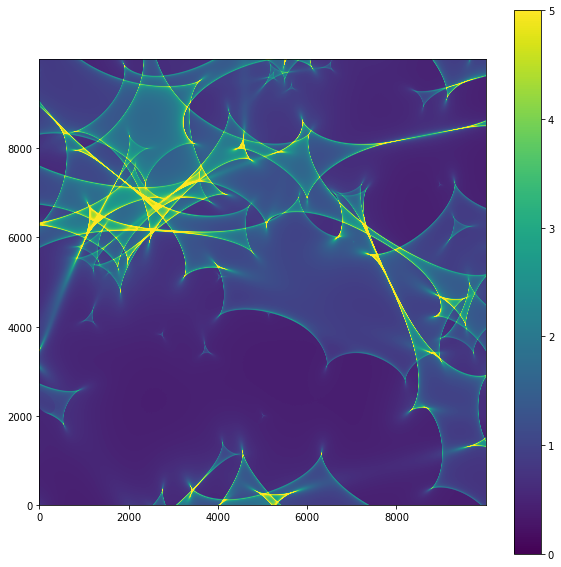

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                10000 / length of data axis 1                          
NAXIS2  =                10000 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CREATOR = 'MICROLENS'          / Created by MICROLENS                           
COMMENT ------- IMPORTANT PARAMETERS: --------                                  
NLENS   =                  556 / total number of lenses within rstars           
NCELL   =                  419 / total number of cells                          
AVLENS  =           7.8855E+

In [23]:
#417 - s1 - 346
#314 - s2 - 347
#length = 5 Einstein radii

map_number = 346

image_data = fits.getdata("maps/IRIS"+str(map_number)+".fits")
image = 10**(.4*(image_data-1024)/256.0)

plt.figure(figsize=(10,10))
plt.imshow(image, origin='lower', vmin=0, vmax = 5)
plt.colorbar()
plt.show()

hdul = fits.open("maps/IRIS"+str(map_number)+".fits")  # open a FITS file
hdr = hdul[0].header  # the primary HDU header
hdr
#print('IRIS'+str(map_number)+':', 'pixmax0 =', hdr['pixmax0'], 'pixminx =', 
#hdr['x-pos'], 'pixminy =', hdr['y-pos'], 'pixdif =', hdr['length'], 'fracpixd =', 
#hdr['fracpixd'], 'kappa_s = ', hdr['sigmas'], 'kappa_c = ', hdr['sigmac'], 'gamma =', hdr['gamma'])

# Определим все необходимые функции

In [44]:
#Запишем функцию, которая генерирует наш фильтр-кружок (маску). Входные параметры:
#rad_pix - радиус фильтра в пикселях (целое число).
#rads, ld - таблично заданное распределение яркости вдоль радиуса фильтра-кружка.

def createMyMask(rad_pix, rads, ld):
    
    w = 2*rad_pix
    h = 2*rad_pix
    
    center = [rad_pix, rad_pix]
    
    dist_from_center = np.zeros((w, h))
    z = dist_from_center*0    
    
    new_grid = rads/np.max(rads) #перенормируем заданное распределение на радиус фильтра (на всякий случай)
    new_grid = new_grid * rad_pix
    
    delta=1 
    x = np.arange(0, w, delta)
    y = np.arange(0, h, delta)

    Y, X = np.meshgrid(x,y)

    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    
    for i in range(0, w):
        for j in range(0, h):
            if dist_from_center[i][j] < rad_pix:
                z[i][j] = np.interp(np.around(dist_from_center[i][j]), new_grid, ld)
            else:
                z[i][j] = 0
    
    return z#/np.sum(z)

#Функция, которая вырезает кружок из карты.

def cut_circle(image, center, rad_pix, graphics):
    
    kusok = np.zeros((2*rad_pix, 2*rad_pix))
    
    for i in range(center[1]-rad_pix, center[1]+rad_pix):
        for j in range(center[0]-rad_pix, center[0]+rad_pix):
             kusok[i - (center[1]-rad_pix)][j - (center[0]-rad_pix)] = image[i][j]
    
    circle_ones = createMyMask(rad_pix, np.arange(0, rad_pix, 1), np.ones(rad_pix))
    mult = np.multiply(circle_ones, kusok)
    
    if graphics:
        
        plt.imshow(image, origin='lower')
        plt.colorbar()
        plt.gca().add_patch( Rectangle( (center[0]-rad_pix, center[1]-rad_pix), 2*rad_pix, 2*rad_pix, fill=None))
        plt.show()

        plt.imshow(kusok, origin='lower')
        plt.colorbar()
        plt.show()

        plt.imshow(mult, origin='lower')
        plt.colorbar()
        plt.show()
    
    return mult

#Считаем флуктуации от микролинзирования

#По какому закону расширяется сверхновая?

def radius_in_time(tau):
  
  velocity = 1  #пусть у нас будет такой коэффициент линейной связи радиуса и времени
  r_0 = 2      #начальный радиус не может быть нулевым

  return int(velocity * tau + r_0)

#Функция, которая считает флуктуации от микролинзирования. Входные параметры:
#mapp - карта микролинзирования,
#cntr - точка, в которой сверхновая начинает расширение,
#max_radius - максимальный радиус сверхновой,
#time_grid - массив с сеткой по времени,
#rads_grid - двумерный массив с сеткой по координатам вдоль радиуса для каждого момента времени,
#light_grid_gauss, light_grid_flat - двумерный массив, содержащий значения яркости вдоль радиуса для гаусового источника и для точечного соответственно для каждого момента времени,
#Graphics - выводит или не выводит промежуточные иллюстрации,
#dividebymedian - деление значений флуктуаций на медианное,
#plot - график (как в sntd).

def micro(mapp, cntr, max_radius, time_grid, rads_grid, light_grid_gauss, 
          light_grid_flat, Graphics=False, dividebymedian=True, plot=True):

    #cформируем рабочие массивы

    mu_gauss = np.zeros(len(time_grid))
    mu_flat = np.zeros(len(time_grid))
    
    t_0 = time.time() #оценка времени выполнения блока
    
    for t in range(0, len(time_grid)):

        radius_now = radius_in_time(time_grid[t])

        if radius_now < max_radius:
            
            if Graphics == True:
              print('Radius is', radius_now, 'pixels now. Profile at this moment:')
              #plt.plot(rads_grid[t][1:radius_now], light_grid_flat[t][1:radius_now])
              plt.plot(rads_grid[t][1:radius_now], light_grid_gauss[t][1:radius_now])
              plt.xlim((0,100))
              plt.show()

            mask_now_gauss = createMyMask(radius_now, rads_grid[t][1:radius_now], light_grid_gauss[t][1:radius_now])
            mask_now_flat = createMyMask(radius_now, rads_grid[t][1:radius_now], light_grid_flat[t][1:radius_now])

            #if Graphics == True:
            #  plt.imshow(mask_now_gauss)
            #  plt.colorbar()
            #  plt.show()

            #svertka_now_gauss = convolve(image, mask_now_gauss, mode='same') 
            #svertka_now_flat = convolve(image, mask_now_flat, mode='same')

            #plt.imshow(svertka_now_gauss)
            #plt.colorbar()
            #plt.show()        

            cut_now = cut_circle(mapp, cntr, radius_now, graphics=False)

            #if Graphics == True:
            #  plt.imshow(cut_now)
            #  plt.colorbar()
            #  plt.show()

            mult_gauss = np.multiply(cut_now, mask_now_gauss)
            mult_flat = np.multiply(cut_now, mask_now_flat)

            #if Graphics == True:
            #  plt.imshow(mult_gauss)
            #  plt.colorbar()
            #  plt.show()

            mu_gauss[t] = float(mult_gauss.sum())/float(mask_now_gauss.sum())
            mu_flat[t] = float(mult_flat.sum())/float(mask_now_flat.sum())

            #print(velocity, time_grid[t], r_0, radius_now)
            clear_output()
            print(round( t/len(time_grid)*100 ), '% completed.', round( time.time() - t_0 ), 'seconds passed')

        else:
            print('Ooops, radius_now =', radius_now,'>',max_radius) #ограничим радиус сверху
            sys.exit()

    clear_output()
    print('Completed in', round( time.time() - t_0 ), 'seconds')

    if plot:

        plt.figure(figsize=(8,8))
        plt.imshow(image, origin='lower')
        plt.gca().add_patch( plt.Circle(center, max_radius, color='red', alpha=0.3) )
        plt.colorbar()
        plt.show()

        plt.figure(figsize=(8,4))
        plt.plot(time_grid, -2.5*np.log10(mu_gauss), label='gauss')
        plt.plot(time_grid, -2.5*np.log10(mu_flat), label='flat')
        #plt.axhline(np.median(mu_gauss), color='r', linestyle='--', label='gauss mean')
        #plt.axhline(np.median(mu_flat), color='g', linestyle='--', label='flat mean')
        plt.gca().invert_yaxis()
        plt.xlabel('Time (arbitrary units)')
        plt.ylabel('$\Delta m$ due microlensing only')
        plt.legend()
        plt.grid()
        plt.show()

    if dividebymedian:
      return -2.5*np.log10(mu_gauss/np.median(mu_gauss)), -2.5*np.log10(mu_flat/np.median(mu_flat))
    else:
      return -2.5*np.log10(mu_gauss), -2.5*np.log10(mu_flat)

# Проверка функций

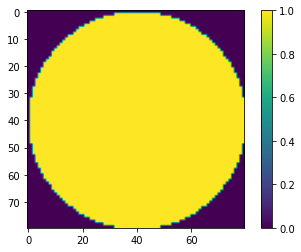

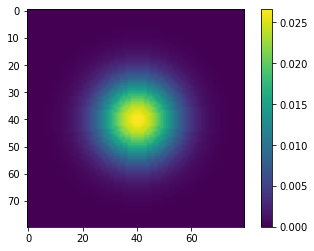

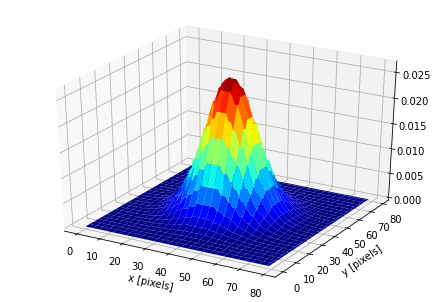

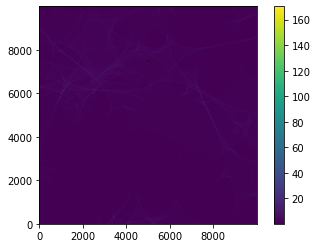

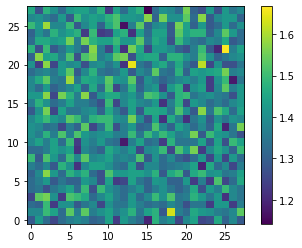

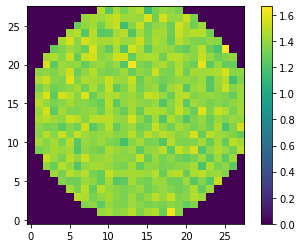

In [24]:
#Проверим её на плоском и на гауссовом источниках

try_radius = 40
try_rads = np.arange(0, 60, 1)

try_ld_flat = np.ones(len(try_rads))
try_mask_flat = createMyMask(try_radius, try_rads, try_ld_flat)

plt.imshow(try_mask_flat)
plt.colorbar()
plt.show()

try_sigma = 15
try_ld_gauss = (1/np.sqrt(2*np.pi)/try_sigma)*np.exp(-try_rads**2/2/try_sigma**2)

try_mask_gauss = createMyMask(try_radius, try_rads, try_ld_gauss)

plt.imshow(try_mask_gauss)
plt.colorbar()
plt.show()

#гауссовый источник дополнительно нарисуем в 3D

import pylab
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

x = np.arange(0,2*try_radius, 1)
y = np.arange(0,2*try_radius, 1)

X,Y = np.meshgrid(x, y)

fig = pylab.figure()
axes = Axes3D(fig)

axes.plot_surface(X,Y, try_mask_gauss, rstride=3, cstride=3, cmap=cm.jet)
pylab.xlabel('x [pixels]')
pylab.ylabel('y [pixels]')

pylab.show()

#вырежем кружок из карты

cut = cut_circle(image, (5000, 7500), 14, graphics=True)

#plt.imshow(cut)
#plt.colorbar()
#plt.show()

# Рабочий процесс

Входные данные:

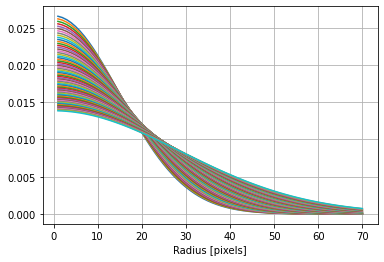

In [42]:
max_radius = 72

max_time = max_radius - 2

time_grid = np.arange(0, max_time, 1)

#зададим данные (распределения яркости в различные моменты времени)

rads_grid = np.zeros( (len(time_grid), max_radius) )
light_grid_gauss = np.zeros( (len(time_grid), max_radius) )
light_grid_flat = np.ones( (len(time_grid), max_radius) )/len(time_grid)

for j in range( 0, len(time_grid) ):
    for k in range( 0, max_radius ):

        rads_grid[j][k] = k 

        sigma = 15 + time_grid[j]/5 #пускай для начала зависимость будет такой
       
        light_grid_gauss[j][k] = (1/np.sqrt(2*np.pi)/sigma)*np.exp(-rads_grid[j][k]**2/2/sigma**2)    
        
    plt.plot(rads_grid[j][1:k], light_grid_gauss[j][1:k])#, color='blue')
#plt.plot(rads_grid[j][1:k], light_grid_flat[j][1:k])
plt.grid()
#plt.ylim(-0.01, 0.08)
plt.xlabel('Radius [pixels]')
plt.show()

In [45]:
attempts = 30

everything = np.zeros(2+1+3*len(time_grid))

for i in range(attempts):

  xx = 100 + np.int(8000*np.random.random())
  yy = 100 + np.int(8000*np.random.random())
  center = (xx, yy)
  
  dm_gauss, dm_flat = micro(image, center, max_radius, time_grid, rads_grid, light_grid_gauss, light_grid_flat, dividebymedian=False, plot=False)

  new_row = [*center, len(time_grid), *time_grid, *dm_gauss, *dm_flat]

  everything = np.vstack( (everything, new_row) )

Completed in 16 seconds


In [47]:
pd.DataFrame(everything).drop(0).to_csv('data/micro_data_S1_big.csv', index=False)

In [48]:
fluct = everything
length = max_time

xxs = fluct[:, 0]
yys = fluct[:, 1]
lengths = fluct[:,2].astype(int)
time_grids = fluct[:, 3:3+length]
dm_gausss = fluct[:, 3+length:3+2*length]
dm_flats = fluct[:, 3+2*length:3+3*length]

Number 0 , center = ( 0.0 , 0.0 )


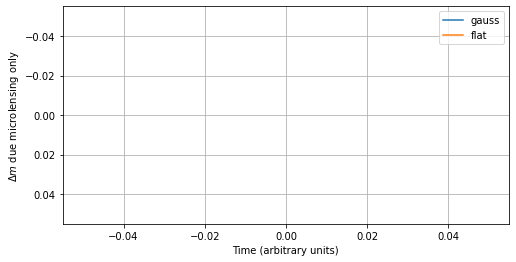

Number 1 , center = ( 1204.0 , 3989.0 )


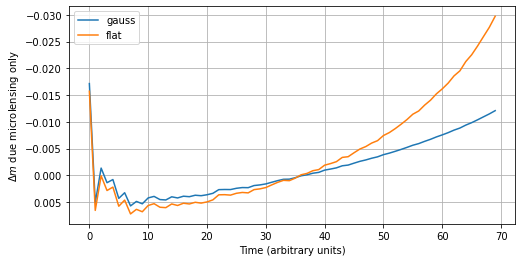

Number 2 , center = ( 4839.0 , 3882.0 )


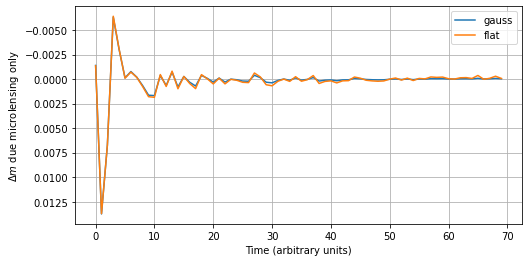

Number 3 , center = ( 1482.0 , 6916.0 )


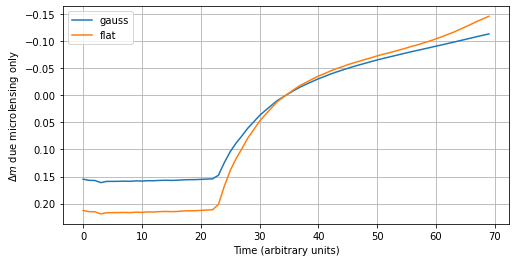

Number 4 , center = ( 7793.0 , 6372.0 )


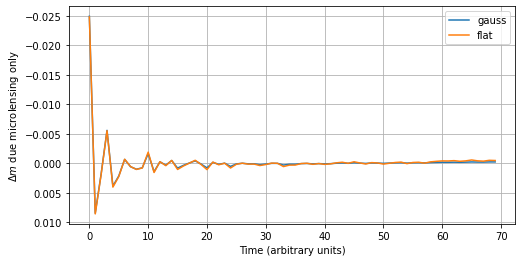

Number 5 , center = ( 7287.0 , 5372.0 )


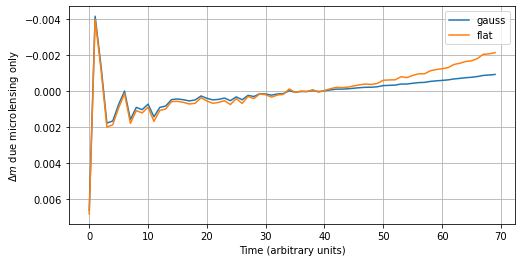

Number 6 , center = ( 3975.0 , 2856.0 )


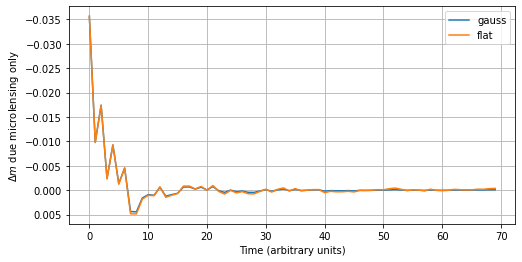

Number 7 , center = ( 254.0 , 3497.0 )


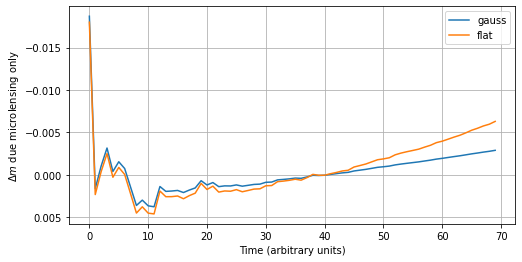

Number 8 , center = ( 2075.0 , 8046.0 )


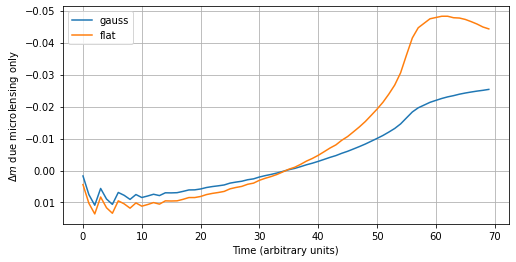

Number 9 , center = ( 498.0 , 2718.0 )


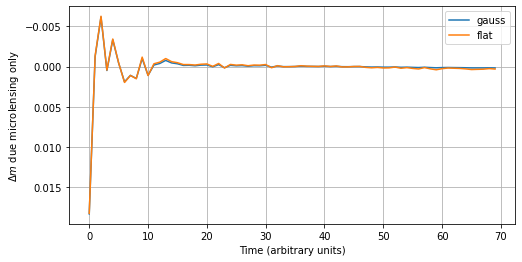

Number 10 , center = ( 1841.0 , 7196.0 )


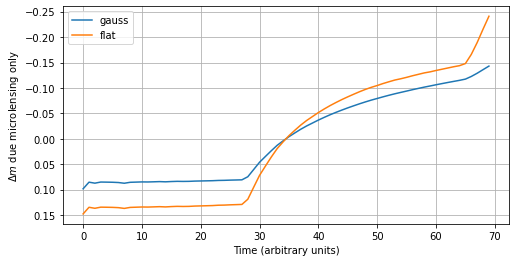

Number 11 , center = ( 1633.0 , 4023.0 )


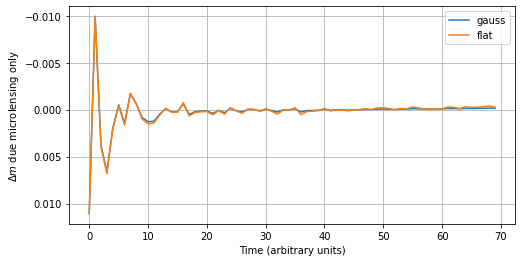

Number 12 , center = ( 2459.0 , 5340.0 )


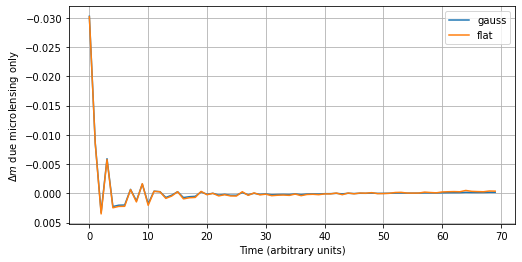

Number 13 , center = ( 1591.0 , 5572.0 )


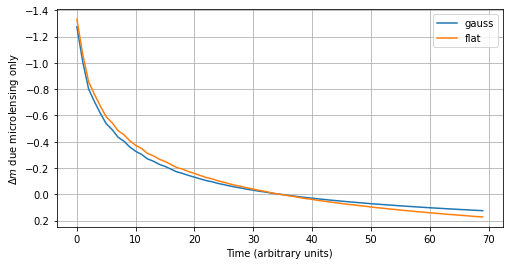

Number 14 , center = ( 2123.0 , 6063.0 )


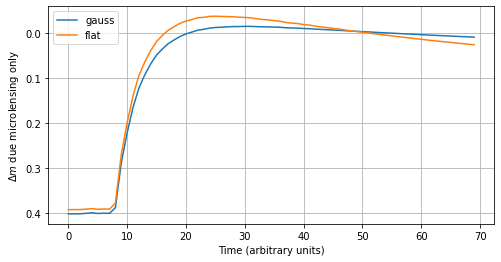

Number 15 , center = ( 3761.0 , 968.0 )


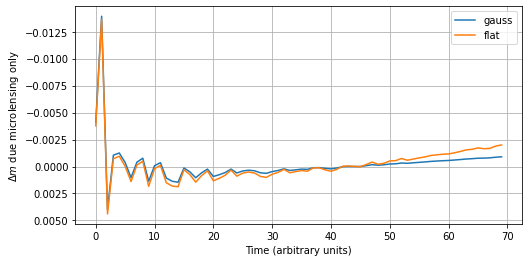

Number 16 , center = ( 2232.0 , 5363.0 )


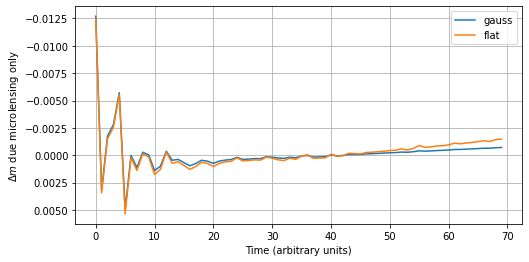

Number 17 , center = ( 1935.0 , 2637.0 )


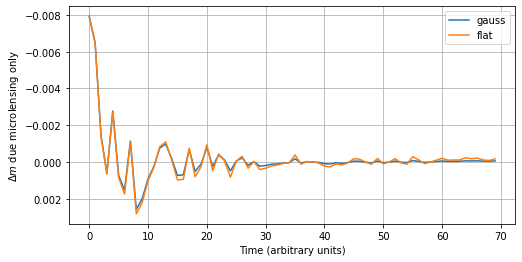

Number 18 , center = ( 4431.0 , 2734.0 )


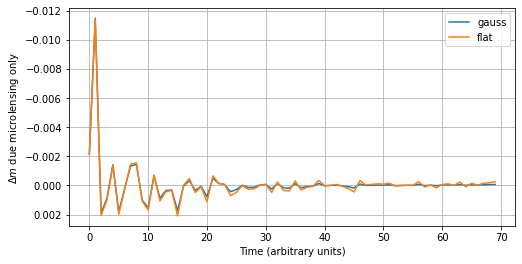

Number 19 , center = ( 5384.0 , 3008.0 )


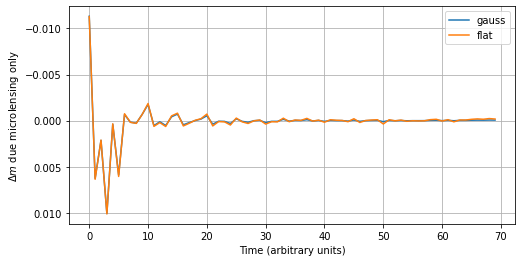

Number 20 , center = ( 5360.0 , 7921.0 )


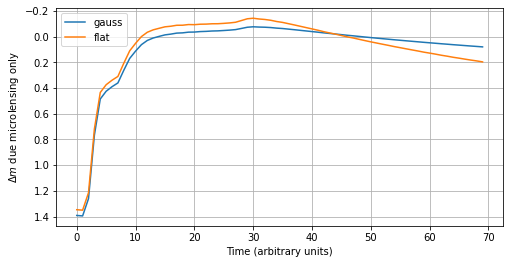

Number 21 , center = ( 4932.0 , 6515.0 )


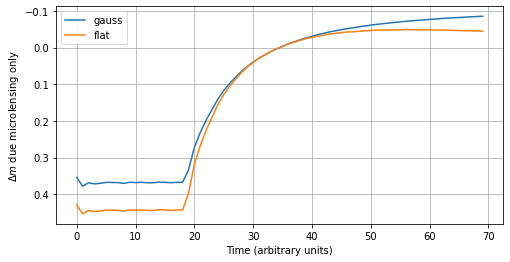

Number 22 , center = ( 644.0 , 4431.0 )


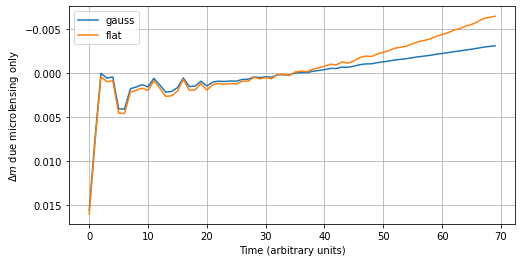

Number 23 , center = ( 1582.0 , 593.0 )


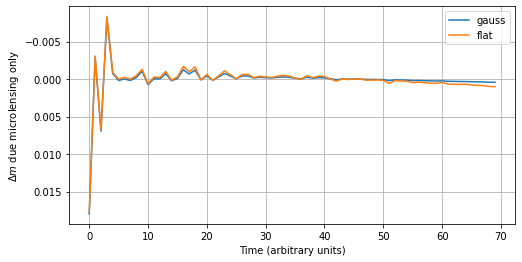

Number 24 , center = ( 4515.0 , 2517.0 )


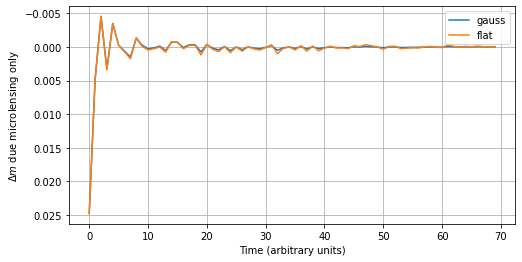

Number 25 , center = ( 6371.0 , 5736.0 )


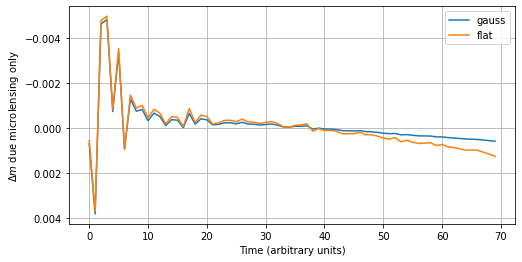

Number 26 , center = ( 4908.0 , 1560.0 )


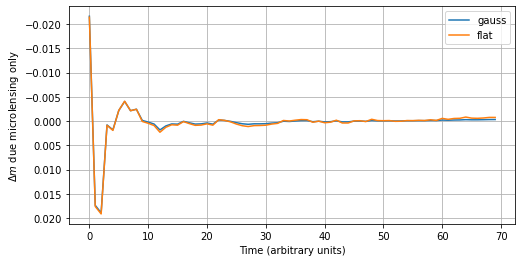

Number 27 , center = ( 2336.0 , 2971.0 )


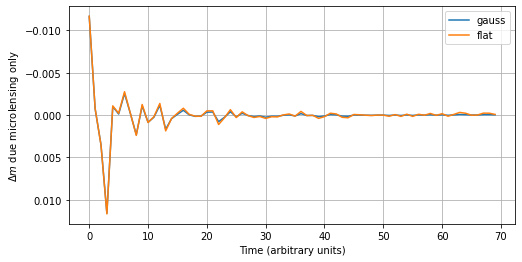

Number 28 , center = ( 697.0 , 7736.0 )


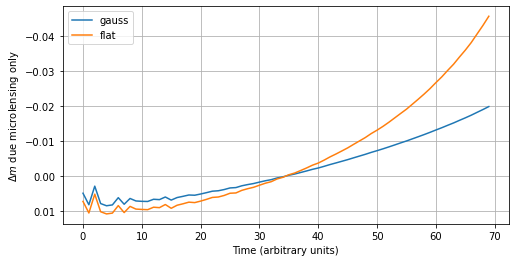

Number 29 , center = ( 6604.0 , 6417.0 )


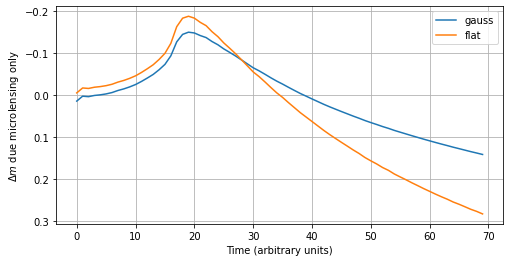

Number 30 , center = ( 3469.0 , 7946.0 )


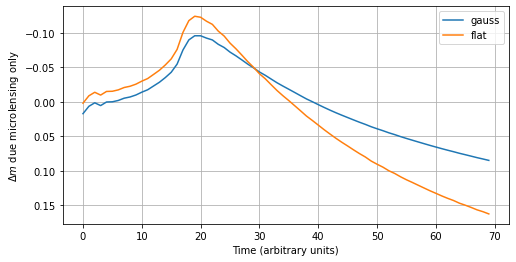

In [49]:
for j in range(0, len(fluct)):

  xx = xxs[j]
  yy = yys[j]
  length = lengths[j]
  time_grid = time_grids[j]
  dm_gauss = dm_gausss[j]
  dm_flat = dm_flats[j]
  
  print('Number', j, ', center = (', xx, ',', yy,')')
  
  plt.figure(figsize=(8,4))
  plt.plot(time_grid, dm_gauss - np.median(dm_gauss), label='gauss')
  plt.plot(time_grid, dm_flat - np.median(dm_flat), label='flat')
  #plt.axvline(50, color='r', linestyle = '--')
  #plt.axhline(np.median(dm_gauss), color='r', linestyle='--', label='gauss mean')
  #plt.axhline(np.median(dm_flat), color='g', linestyle='--', label='flat mean')
  plt.gca().invert_yaxis()
  plt.xlabel('Time (arbitrary units)')
  plt.ylabel('$\Delta m$ due microlensing only')
  #plt.title('FLAT')
  plt.legend()
  plt.grid()
  plt.show()

# Сравниваем результаты с SNTD (для карт 1000х1000)

In [ ]:
! pip install sntd

clear_output()

Сверим полученные результаты с работой SNTD.

Assuming velocity is in km/s.


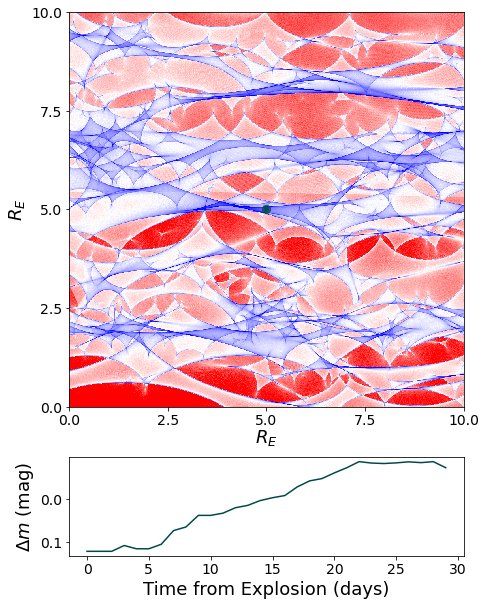

In [ ]:
import sntd

center = (500,500)

time1,dmag1 = sntd.microcaustic_field_to_curve(field = image_data,time=np.arange(0, 30,1), ax=None, zl=.541,zs=1.488, 
                                           velocity=20000,width_in_einstein_radii=10, plot=True, loc=center, rescale=True)
plt.show()

Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.


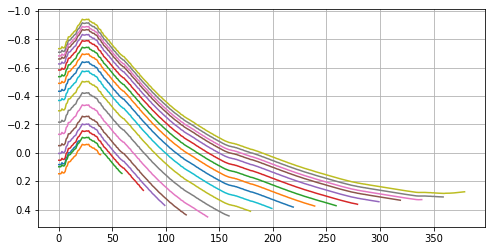

In [ ]:
plt.figure(figsize=(8,4))
plt.gca().invert_yaxis()
plt.grid()

sizes = 20

for i in range(1, sizes):

  center = (500, 500)

  time1,dmag1 = sntd.microcaustic_field_to_curve(field = image_data,time=np.arange(0, 20*i,1), ax=None, zl=.541,zs=1.488, 
                                                  velocity=20000,width_in_einstein_radii=10, plot=False, loc=center, rescale=True)

  plt.plot(time1, -2.5*np.log10(dmag1))

plt.savefig('check.jpg')
plt.show()

Для равномерно засвеченного источника получилось похоже. Сравним флуктуации поточечно.

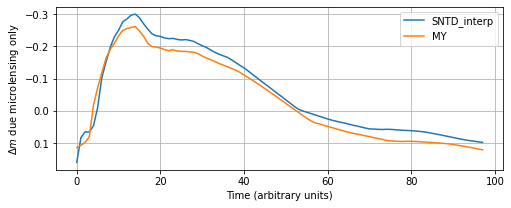

In [ ]:
plt.figure(figsize=(8,3))

factor = len(time1)/len(time_grid) 

sntd_to_my = np.interp(time_grid*factor, time1, -2.5*np.log10(dmag1))

plt.plot(time_grid, sntd_to_my, label='SNTD_interp')
plt.plot(time_grid, dm_flat, label='MY')

plt.gca().invert_yaxis()
plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
plt.grid()
plt.legend()
plt.savefig('1.png')
plt.show()

#plt.show()

# А) Карта из GERLUMPH

Вытащим параметры карты из файла mapmeta.dat:

In [ ]:
avmag = 13.0884
avnumrays_perpix = 411.083

res = 10000
length = 25

kappa = 0.72
gamma = 0.1
kappa_c = 0.300

mean_magn = 1./((1.-kappa)**2 - gamma**2)
mean_magn

14.619883040935669

Откроем карту и перемасштабируем её:

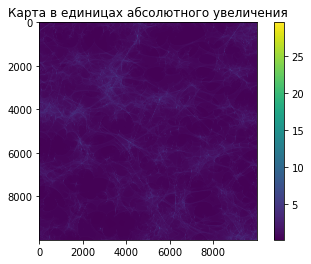

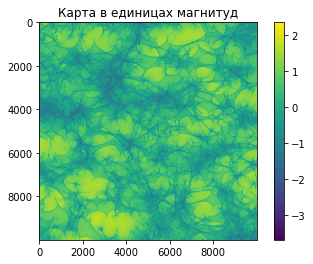

(2.0, -3.0)

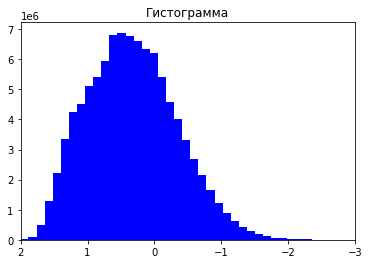

In [ ]:
filename = ("maps/Gerlumph/map.bin")
mapp = open(filename,"rb")
image = np.fromfile(mapp,'i',-1,"")

image = image * avmag / avnumrays_perpix / mean_magn

image = image.reshape(int(res), int(res))

#plt.figure(figsize = (20,20))

plt.imshow(image)#, vmin=0, vmax = 5)
plt.title('Карта в единицах абсолютного увеличения')
plt.colorbar()
plt.show()

image_mod = -2.5*np.log10(image)

plt.imshow(image_mod)
plt.title('Карта в единицах магнитуд')
plt.colorbar()
plt.show()

plt.hist(image_mod.flatten(), bins=50,color='blue')
plt.title('Гистограмма')
plt.xlim(2,-3)

# Карта-ступенька

Сформируем карту-"ступеньку".

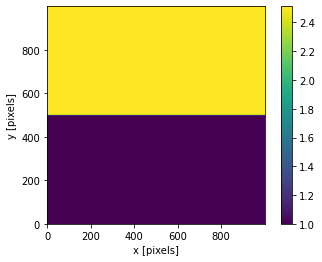

In [ ]:
side = 1000

stupenka_data = np.zeros((side, side))

for i in range(0, side):
    for j in range(0, side):
        if i<int(side/2):
            stupenka_data[i][j]=1024
        else:
            stupenka_data[i][j]=1280

stupenka = 10**(.4*(stupenka_data-1024)/256.)
            
plt.imshow(stupenka, origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

# Обзор карт

In [ ]:
#a = fits.open("maps/IRIS314.fits")[0].data
#b = 10**(.4*(a-1024)/256.0)
#a
#plt.imshow(b, origin='lower')
#plt.title("S2 - absolute magnifications")
#plt.colorbar()
#plt.show()

#plt.imshow(-2.5*np.log(b), origin='lower')
#plt.title("S2 - magnitudes")
#plt.colorbar()
#plt.show()

#plt.hist(-2.5*np.log(b.flatten()), bins=100)
#plt.title("Histogram of magnitudes for S2")
#plt.show()

IRIS331: pixmax0 = 1.0 pixminx = -1.0 pixminy = -1.0 pixdif = 2.0 fracpixd = 1.0
kappa_s =  0.207 kappa_c =  0.521 gamma = 0.108 nlens = 362 nray = 300


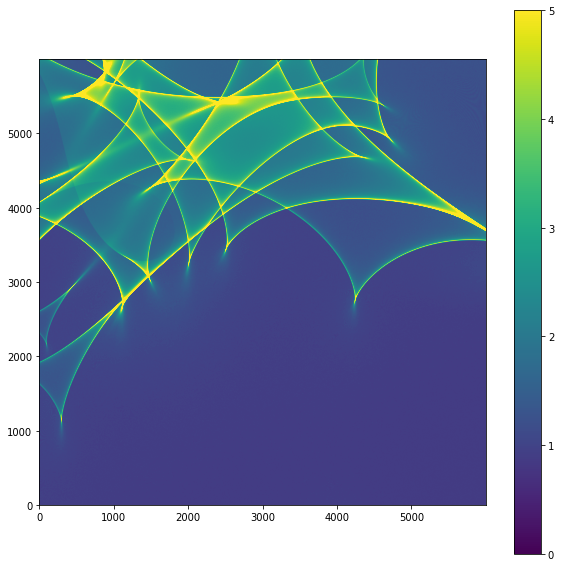

IRIS333: pixmax0 = 1.0 pixminx = -1.0 pixminy = -1.0 pixdif = 2.0 fracpixd = 1.0
kappa_s =  0.207 kappa_c =  0.521 gamma = 0.108 nlens = 362 nray = 600


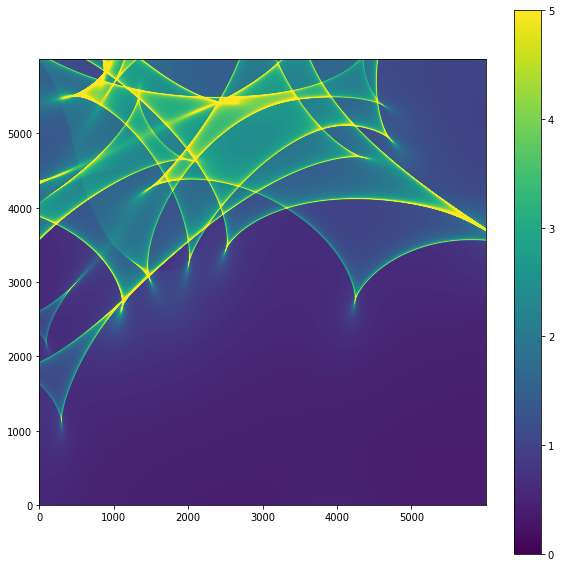

IRIS338: pixmax0 = 2.5 pixminx = -2.5 pixminy = -2.5 pixdif = 5.0 fracpixd = 0.4
kappa_s =  0.207 kappa_c =  0.521 gamma = 0.108 nlens = 556 nray = 600


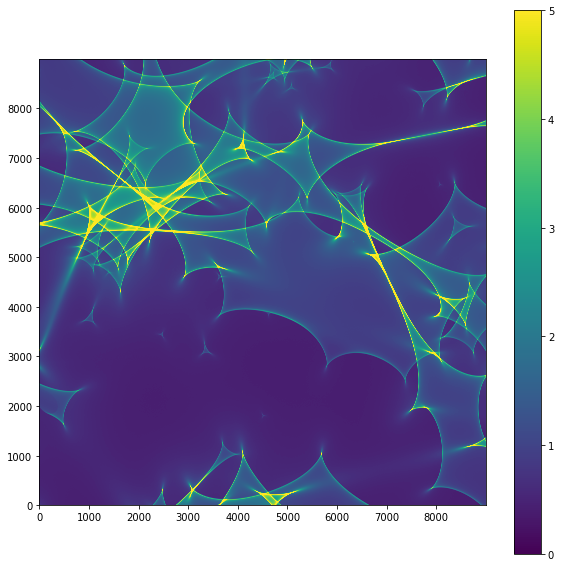

IRIS339: pixmax0 = 2.5 pixminx = -2.5 pixminy = -2.5 pixdif = 5.0 fracpixd = 0.4
kappa_s =  0.207 kappa_c =  0.521 gamma = 0.108 nlens = 556 nray = 600


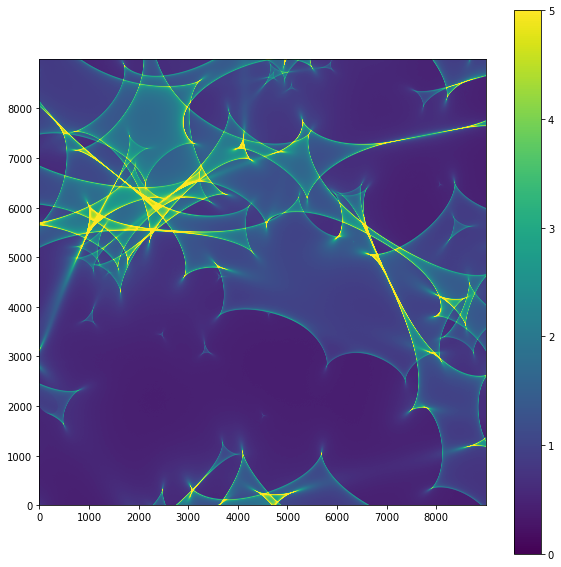

IRIS340: pixmax0 = 5.0 pixminx = -5.0 pixminy = -5.0 pixdif = 10.0 fracpixd = 0.4
kappa_s =  0.207 kappa_c =  0.521 gamma = 0.108 nlens = 969 nray = 600


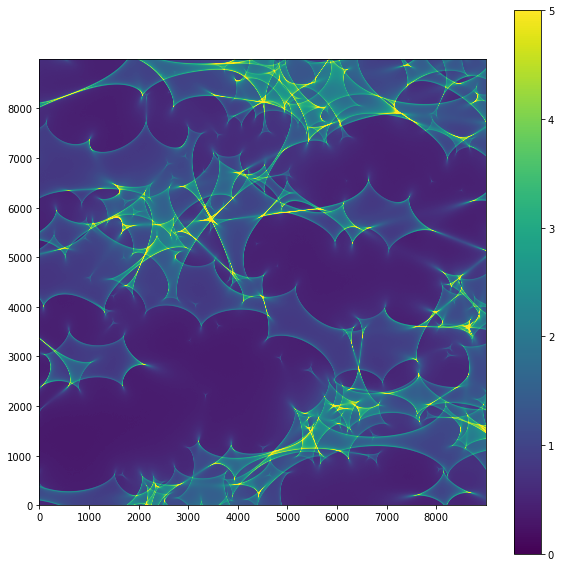

IRIS342: pixmax0 = 5.0 pixminx = -5.0 pixminy = -5.0 pixdif = 10.0 fracpixd = 0.4
kappa_s =  0.207 kappa_c =  0.521 gamma = 0.108 nlens = 969 nray = 1000


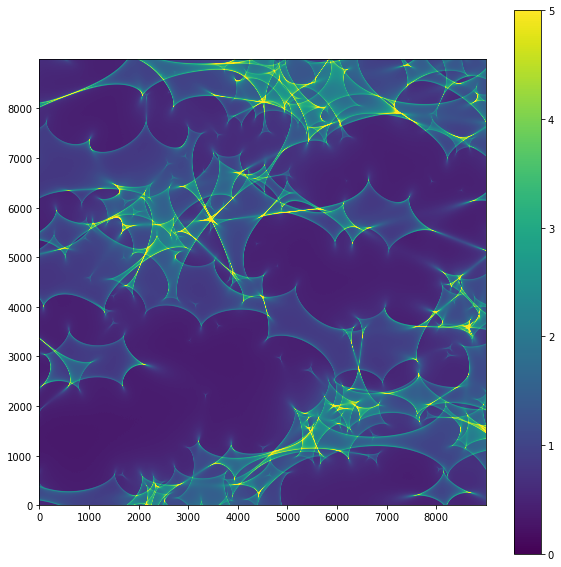

IRIS344: pixmax0 = 5.0 pixminx = -5.0 pixminy = -5.0 pixdif = 10.0 fracpixd = 0.4
kappa_s =  0.207 kappa_c =  0.521 gamma = 0.108 nlens = 969 nray = 2000


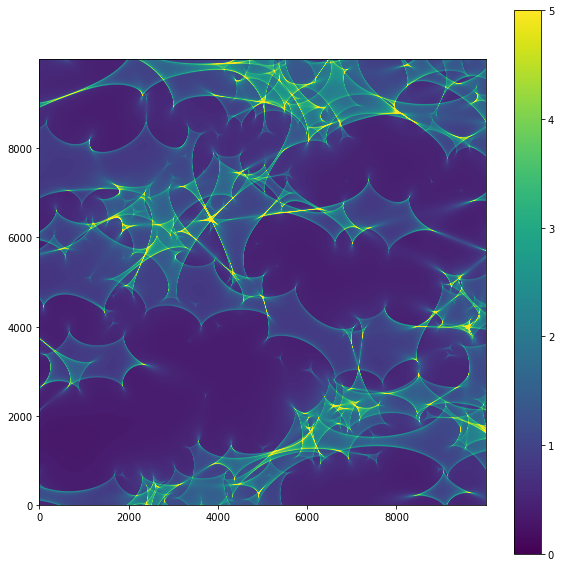

IRIS345: pixmax0 = 5.0 pixminx = -5.0 pixminy = -5.0 pixdif = 10.0 fracpixd = 0.4
kappa_s =  0.207 kappa_c =  0.521 gamma = 0.108 nlens = 969 nray = 3000


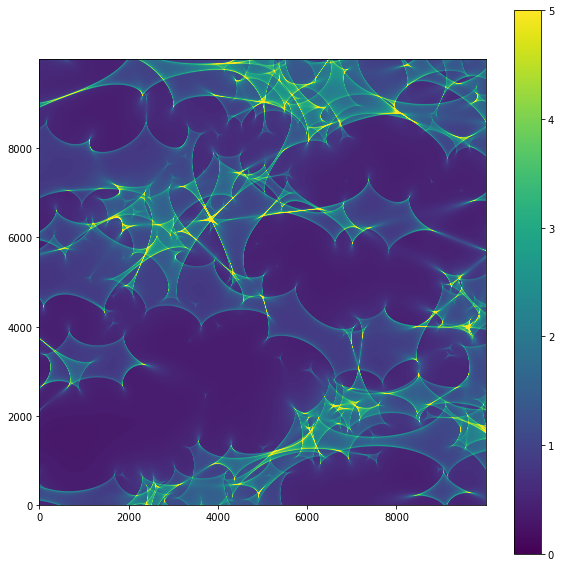

IRIS346: pixmax0 = 2.5 pixminx = -2.5 pixminy = -2.5 pixdif = 5.0 fracpixd = 0.4
kappa_s =  0.207 kappa_c =  0.521 gamma = 0.108 nlens = 556 nray = 2000


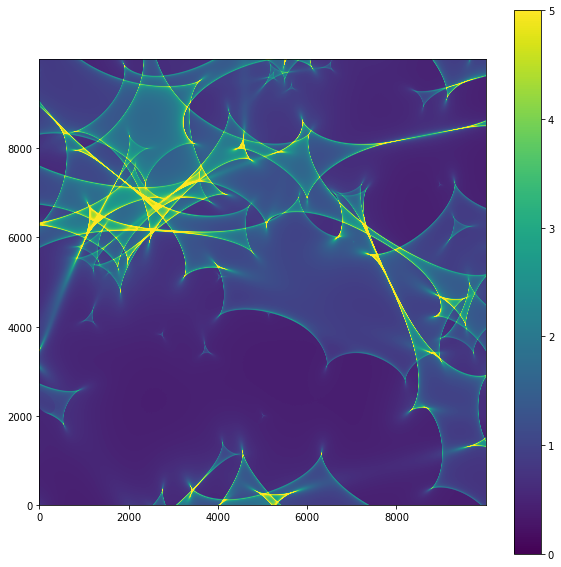

IRIS347: pixmax0 = 2.5 pixminx = -2.5 pixminy = -2.5 pixdif = 5.0 fracpixd = 0.4
kappa_s =  0.228 kappa_c =  0.496 gamma = 0.347 nlens = 2675 nray = 2000


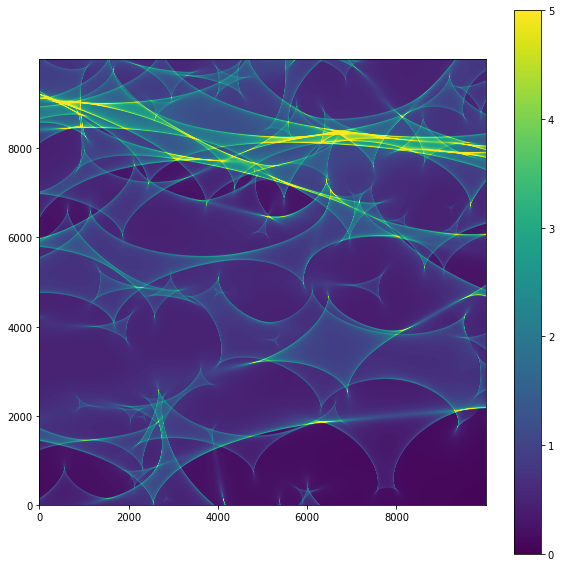

IRIS352: pixmax0 = 2.5 pixminx = -2.5 pixminy = -2.5 pixdif = 5.0 fracpixd = 0.4
kappa_s =  0.207 kappa_c =  0.521 gamma = 0.108 nlens = 556 nray = 500


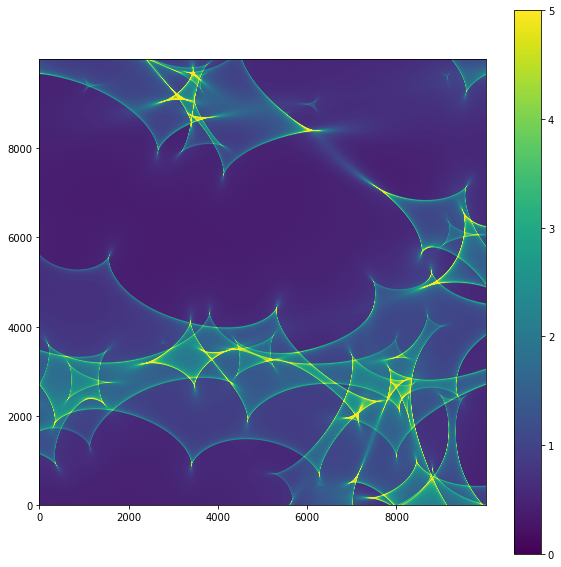

In [18]:
#417 - s1
#314 - s2

#map_number = 344
for map_number in (331, 333, 338, 339, 340, 342, 344, 345, 346, 347, 352):

  hdul = fits.open("maps/IRIS"+str(map_number)+".fits")  # open a FITS file
  hdr = hdul[0].header  # the primary HDU header
  hdr
  print('IRIS'+str(map_number)+':',
        'pixmax0 =', hdr['pixmax0'], 
        'pixminx =', hdr['x-pos'], 
        'pixminy =', hdr['y-pos'], 
        'pixdif =', hdr['length'],
        'fracpixd =', hdr['fracpixd']) 
  print('kappa_s = ', hdr['sigmas'], 
        'kappa_c = ', hdr['sigmac'], 
        'gamma =', hdr['gamma'],
        'nlens =', hdr['nlens'],
        'nray =', hdr['nray'])

  image_data = fits.getdata("maps/IRIS"+str(map_number)+".fits")
  image = 10**(.4*(image_data-1024)/256.0)

  plt.figure(figsize=(10,10))
  plt.imshow(image, origin='lower', vmin=0, vmax = 5)
  plt.colorbar()
  plt.savefig('IRIS'+str(map_number)+'.png')
  plt.show()